# Prepare synthetic survey data for the practicals

https://en.wikipedia.org/wiki/Geology_of_Cape_Town

http://www.scielo.org.za/pdf/sajs/v113n11-12/18.pdf

http://userpage.fu-berlin.de/geodyn/instruments/Manual_Lacoste_GDl.pdf

In [26]:
import pooch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import harmonica as hm
import boule as bl
import pyproj

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the Southern Africa gravity data

In [2]:
data = hm.datasets.fetch_south_africa_gravity()
data = data[data.elevation > 0]
data

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity
43,-34.12971,18.34444,32.2,979656.12
44,-34.08833,18.36028,592.5,979508.21
45,-34.19583,18.37418,18.4,979666.46
47,-34.23972,18.40388,25.0,979671.03
48,-34.16444,18.41112,228.7,979616.11
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


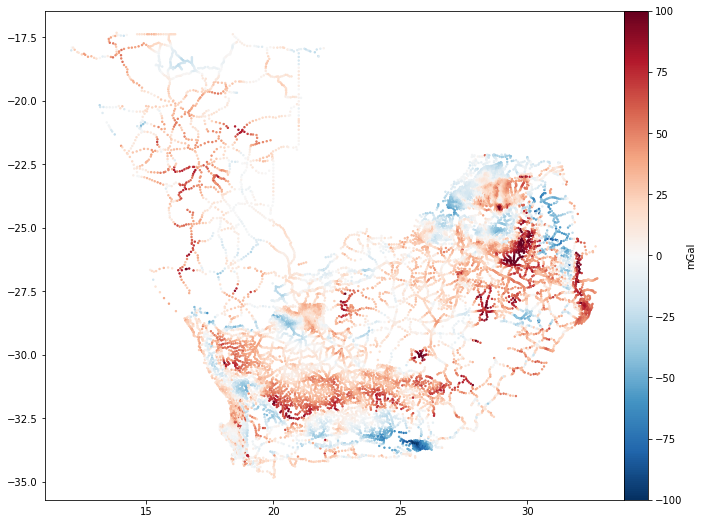

In [84]:
plt.figure(figsize=(14, 9))
plt.scatter(data.longitude, data.latitude, c=data.gravity - bl.WGS84.normal_gravity(data.latitude, data.elevation), s=2, vmin=-100, vmax=100, cmap="RdBu_r")
plt.axis("scaled")
plt.colorbar(pad=0, label="mGal")

## Select a smaller survey area around Cape Town

In [71]:
region = [18, 19, -35, -33.65]
projection = pyproj.Proj("+proj=utm +zone=34H +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
survey = data.loc[vd.inside((data.longitude, data.latitude), region) & (data.elevation < 300)].copy().reset_index(drop=True)
survey["station"] = np.arange(survey.shape[0])
survey["easting"], survey["northing"] = projection(survey.longitude.values, survey.latitude.values)
survey

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,bouguer,station,easting,northing
0,-34.12971,18.34444,32.2,979656.12,2.336569,0,255105.430893,6.220276e+06
1,-34.19583,18.37418,18.4,979666.46,4.409810,1,258037.644761,6.213013e+06
2,-34.23972,18.40388,25.0,979671.03,6.589470,2,260899.254592,6.208215e+06
3,-34.16444,18.41112,228.7,979616.11,-1.942558,3,261353.986978,6.216582e+06
4,-34.29778,18.42557,104.0,979662.74,8.954696,4,263060.437620,6.201825e+06
...,...,...,...,...,...,...,...,...
86,-33.68611,18.87862,183.2,979563.51,-23.458004,86,303360.101970,6.270627e+06
87,-33.75389,18.88222,193.8,979565.46,-25.079210,87,303848.172061,6.263117e+06
88,-33.92944,18.89111,199.2,979581.57,-22.581945,88,305070.978580,6.243665e+06
89,-33.79388,18.95612,144.1,979577.13,-26.523421,89,310782.022418,6.258820e+06


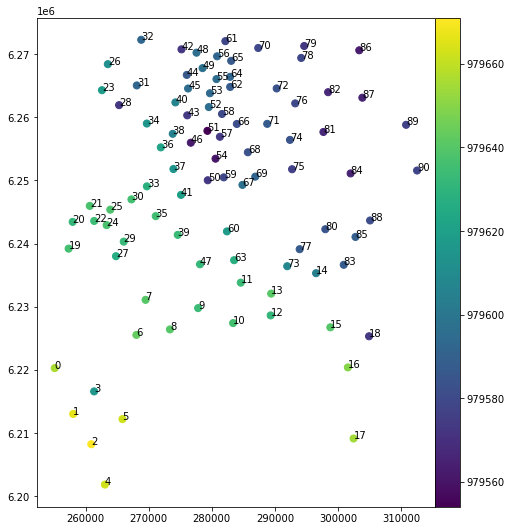

In [86]:
plt.figure(figsize=(14, 9))
ax = plt.subplot(111)
tmp = ax.scatter(survey.easting, survey.northing, c=survey.gravity, s=50)
for i in range(survey.shape[0]):
    ax.text(survey.easting[i], survey.northing[i], str(survey.station[i]))
plt.axis("scaled")
plt.colorbar(tmp, pad=0)

## Split this up into daily surveys

Each of these will represent a day in the field, starting and ending at a base station for drift correction.

In [76]:
base = 0
base_gravity = survey.gravity[base]
survey_stations = [np.concatenate([[base], section, [base]]) for section in np.array_split(survey.station[1:], 5)]
survey_stations

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18,  0]),
 array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36,  0]),
 array([ 0, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54,  0]),
 array([ 0, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72,  0]),
 array([ 0, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90,  0])]

In [77]:
surveys = [survey.iloc[stations].copy().reset_index(drop=True) for stations in survey_stations]
surveys[0]

,latitude,longitude,elevation,gravity,bouguer,station,easting,northing
0,-34.12971,18.34444,32.2,979656.12,2.336569,0,255105.430893,6.220276e+06
1,-34.19583,18.37418,18.4,979666.46,4.409810,1,258037.644761,6.213013e+06
2,-34.23972,18.40388,25.0,979671.03,6.589470,2,260899.254592,6.208215e+06
3,-34.16444,18.41112,228.7,979616.11,-1.942558,3,261353.986978,6.216582e+06
4,-34.29778,18.42557,104.0,979662.74,8.954696,4,263060.437620,6.201825e+06
5,-34.20500,18.45860,8.9,979662.48,-2.209219,5,265844.024991,6.212193e+06
6,-34.08528,18.48611,19.0,979642.88,-9.771637,6,268052.065574,6.225535e+06
7,-34.03555,18.50333,15.1,979640.22,-9.028679,7,269506.569984,6.231090e+06
8,-34.07861,18.54388,34.7,979640.33,-8.674113,8,273365.758468,6.226405e+06
9,-34.04916,18.59306,59.6,979633.95,-7.686953,9,277827.863637,6.229779e+06


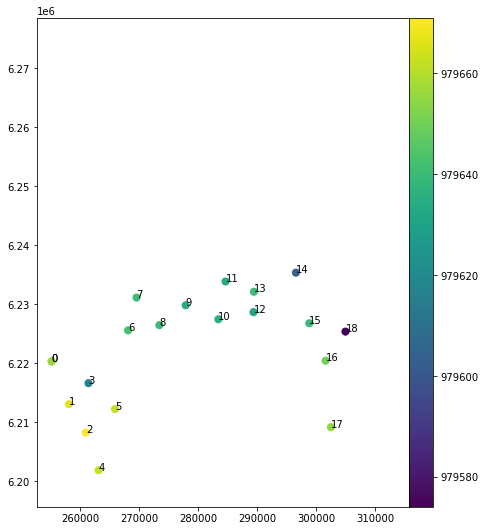

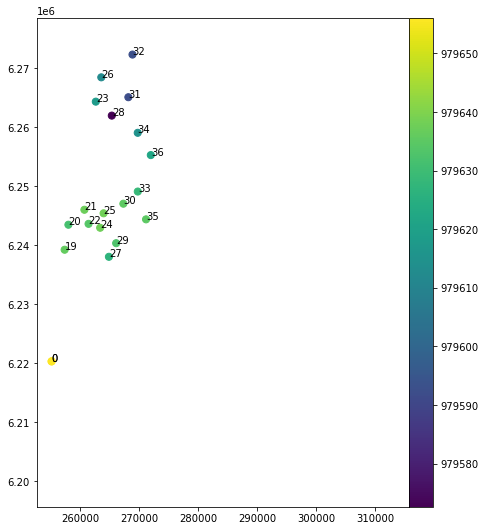

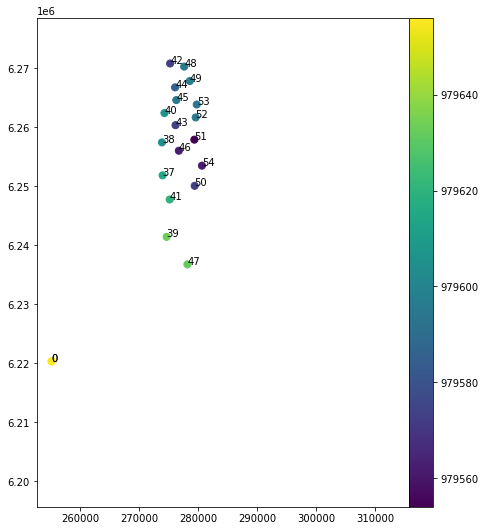

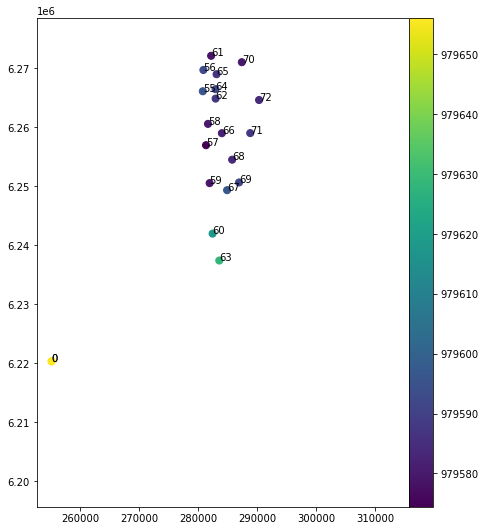

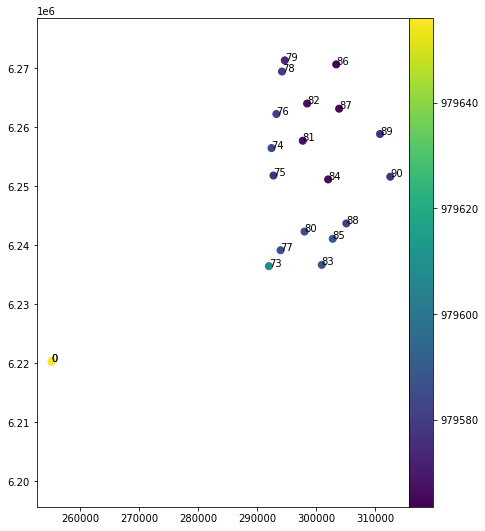

In [92]:
for j in range(len(surveys)):
    plt.figure(figsize=(14, 9))
    plt.scatter(surveys[j].easting, surveys[j].northing, c=surveys[j].gravity, s=50)
    for i in range(surveys[j].shape[0]):
        plt.text(surveys[j].easting.iloc[i], surveys[j].northing.iloc[i], str(surveys[j].station.iloc[i]))
    plt.axis("scaled")
    plt.xlim(survey.easting.min()*0.99, survey.easting.max()*1.01)
    plt.ylim(survey.northing.min()*0.999, survey.northing.max()*1.001)
    plt.colorbar(pad=0)

## Convert the gravity values to relative readings

Subtract from the base station gravity and add a factor so that it's around 2500 (rough range for latitude of -30). The factor should vary from day to day by a small factor.

## Convert readings from mGal to L&G gravimeter scale divisions


Use the conversion table for the Liverpool gravimeter. 

## Apply fake drift correction to readings

Generate a slightly different one for each day.